# Predikcija konačne ocene i verovatnoće da će student upisati visokoškolsko obrazovanje

Cilj projekta je predviđanje konačne ocene studenata na osnovu različitih parametara, kao i odluke da li će student upisati visokoškolsko obrazovanje, omogućiće razumevanje faktora koji utiču na akademski uspeh studenata.

1.	Prikupljanje i Analiza Podataka:

•	Učitavanje i istraživanje skupa podataka o studentima.

•	Vizualizacija raspodele ocena, demografskih podataka i drugih relevantnih informacija.


In [21]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from utils_nans1 import *

# učitavamo podatke i ispis prvih nekoliko redova 

df = pd.read_csv('data/portuguese_train.csv', sep=',')
df.head()

,student_id,school,sex,age,address_type,family_size,parent_status,mother_education,father_education,mother_job,...,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
0,70,GP,F,15,Rural,Less than or equal to 3,Living together,secondary education,primary education (4th grade),other,...,4,4,2,2,3,3,6,15,15,15
1,71,GP,M,16,Urban,Greater than 3,Living together,secondary education,primary education (4th grade),other,...,4,3,2,1,1,5,2,13,11,11
2,72,GP,M,15,Urban,Greater than 3,Living together,higher education,5th to 9th grade,other,...,3,3,3,1,1,3,0,11,9,10
3,73,GP,F,15,Rural,Greater than 3,Living together,primary education (4th grade),primary education (4th grade),other,...,3,3,4,2,4,5,2,13,11,11
4,74,GP,M,16,Urban,Greater than 3,Living together,secondary education,primary education (4th grade),other,...,5,3,2,2,2,5,0,13,13,14


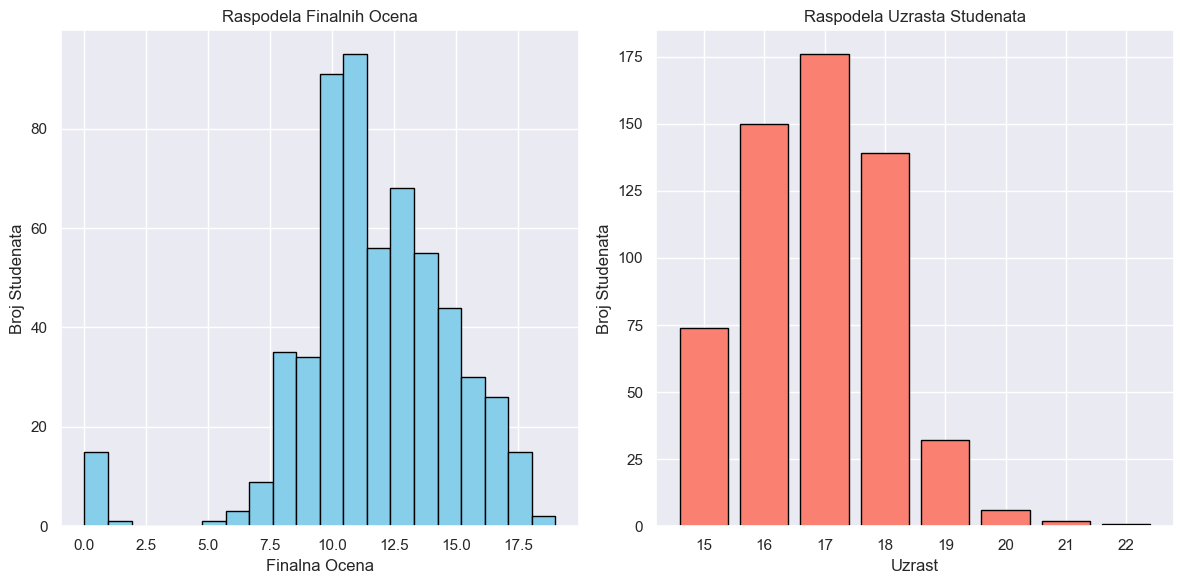

In [22]:
file_path = 'data/portuguese_train.csv' 
data = pd.read_csv(file_path)

# Vizualizacija raspodele ocena na osnovu train podataka
plt.figure(figsize=(12, 6))

# Histogram finalnih ocena
plt.subplot(1, 2, 1)
plt.hist(data['final_grade'], bins=20, color='skyblue', edgecolor='black')
plt.title('Raspodela Finalnih Ocena')
plt.xlabel('Finalna Ocena')
plt.ylabel('Broj Studenata')

# Vizualizacija demografskih podataka (primer: uzrast)
plt.subplot(1, 2, 2)
plt.bar(data['age'].value_counts().index, data['age'].value_counts().values, color='salmon', edgecolor='black')
plt.title('Raspodela Uzrasta Studenata')
plt.xlabel('Uzrast')
plt.ylabel('Broj Studenata')

plt.tight_layout()
plt.show()


2.	Priprema Podataka:

•	Obrada nedostajućih vrednosti.

•	Kodiranje kategoričkih podataka.

•	Normalizacija numeričkih podataka.


In [23]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Učitani trening podaci 
train_file_path = "data/portuguese_train.csv"
train_data = pd.read_csv(train_file_path)

# Učitani test podaci
test_file_path = "data/portuguese_test.csv"
test_data = pd.read_csv(test_file_path)

# Podeli trening podatke na ulazne (X_train) i izlazne (y_train) promenljive
X_train = train_data.drop("final_grade", axis=1)
y_train = train_data["final_grade"]

# Podeli test podatke na ulazne (X_test) i izlazne (y_test) promenljive
X_test = test_data.drop("final_grade", axis=1)
y_test = test_data["final_grade"]

# Definiši kolone koje treba obraditi (moramo paziti na tipove podataka koje uporedjujemo)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

#popunjava nedostajuce vrednosti srednjom vrednoscu
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

#popunjava nedostajuce vrednosti najcescom vrednoscu
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) #OneHotEncoder konvertuje u binarnu reprezenntaciju
])

#kombinujemo prethodna dva
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#  konačan model
model = Pipeline(steps=[('preprocessor', preprocessor)])

#  preprocesiranje na trening podacima
X_train_preprocessed = model.fit_transform(X_train)

#  preprocesiranje na test podacima
X_test_preprocessed = model.transform(X_test)


3.	Modeliranje:

•	Podela skupa podataka na trening, validacioni i test set.(70% za trening, 15% za validaciju i 15% za testiranje.)


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Učitaj podatke
file_path = "data/portuguese_train.csv"
data = pd.read_csv(file_path)

# Izdvoji X i y
X = data.drop(["student_id", "final_grade"], axis=1)
y = data["final_grade"]

# Podela podataka na trening, validacioni i test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Ispis veličina setova 
print(f"Veličina trening skupa: {X_train.shape[0]} instanci")
print(f"Veličina validacionog skupa: {X_val.shape[0]} instanci")
print(f"Veličina test skupa: {X_test.shape[0]} instanci")


Veličina trening skupa: 406 instanci
Veličina validacionog skupa: 87 instanci
Veličina test skupa: 87 instanci


•	Implementacija multivarijabilne regresije na finalnu ocenu sa L1 normom (lasso), L2 normom (ridge) i Elastic net (l1 + l2).

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Učitaj podatke
file_path = "data/portuguese_train.csv"
data = pd.read_csv(file_path)

# Izdvoji X i y
X = data.drop(["student_id", "final_grade"], axis=1)
y = data["final_grade"]  # Promeni target promenljivu na "final_grade"

# Koristi LabelEncoder za konvertovanje "yes" i "no" u numeričke vrednosti
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Podela podataka na trening i test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Definiši kolone koje treba obraditi
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Remove "final_grade" from categorical features
categorical_features = categorical_features.difference(["final_grade"])

# Create transformers
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers for all columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# L1 norma (Lasso)
lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=0.01))
])

# L2 norma (Ridge)
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=0.01))
])

# Elastic Net (L1 + L2)
elastic_net_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('elastic_net', ElasticNet(alpha=0.01, l1_ratio=0.5))
])

# Fituj modele na trening podacima
lasso_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
elastic_net_model.fit(X_train, y_train)

# Evaluacija modela na test setu
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"L1 norma (Lasso) - MSE: {mse_lasso}")

y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"L2 norma (Ridge) - MSE: {mse_ridge}")

y_pred_elastic_net = elastic_net_model.predict(X_test)
mse_elastic_net = mean_squared_error(y_test, y_pred_elastic_net)
print(f"Elastic Net - MSE: {mse_elastic_net}")

feature_importance = pd.Series(lasso_model.named_steps['lasso'].coef_, index=lasso_model.named_steps['preprocessor'].get_feature_names_out(X.columns))
print("Feature importance:", feature_importance)


L1 norma (Lasso) - MSE: 0.8165293708168292
L2 norma (Ridge) - MSE: 0.8833016804854154
Elastic Net - MSE: 0.8333725054853597
Feature importance: num__age                              0.127232
num__class_failures                  -0.152967
num__family_relationship             -0.000000
num__free_time                       -0.030755
num__social                          -0.053459
                                        ...   
cat__study_time_>10 hours            -0.000000
cat__travel_time_15 to 30 min.       -0.000000
cat__travel_time_30 min. to 1 hour    0.001532
cat__travel_time_<15 min.            -0.003840
cat__travel_time_>1 hour              0.000000
Length: 72, dtype: float64


•	Korelaciona analiza i primena Principal Component Analysis za smanjenje dimenzionalnosti.

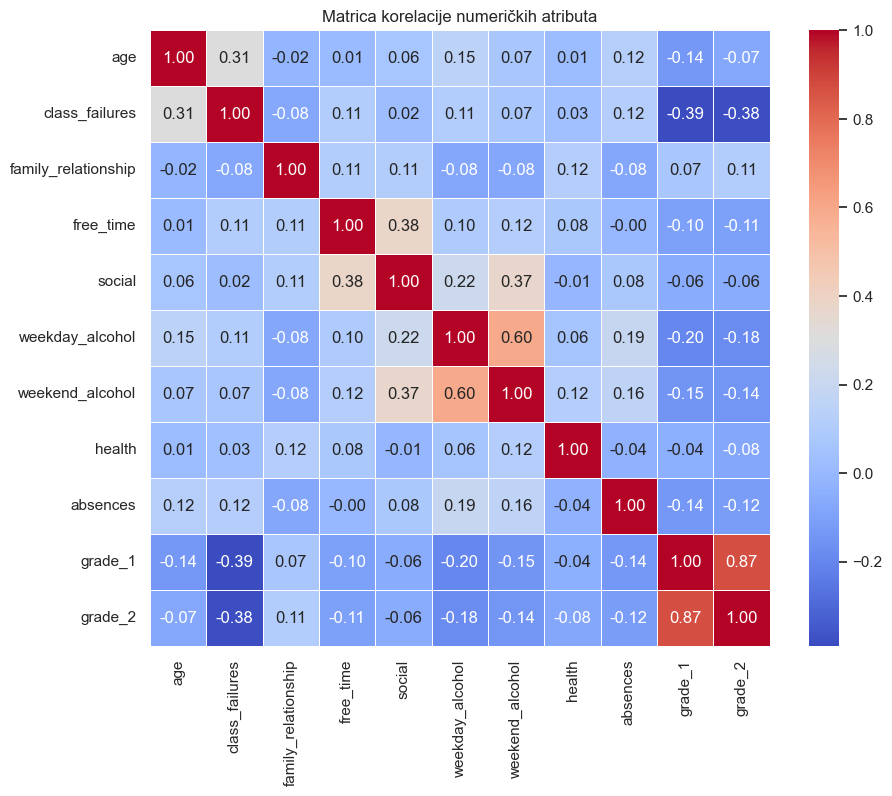

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Učitaj podatke
file_path = "data/portuguese_train.csv"
data = pd.read_csv(file_path)

# Izdvoji X i y
X = data.drop(["student_id", "final_grade"], axis=1)
y = data["final_grade"]

# Izdvoji kolone grade_1, grade_2 i final_grade
grades = data[["grade_1", "grade_2", "final_grade"]]

# Vizualizacija korelacija između numeričkih atributa
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_data = X[numeric_features]
numeric_corr_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrica korelacije numeričkih atributa')
plt.show()







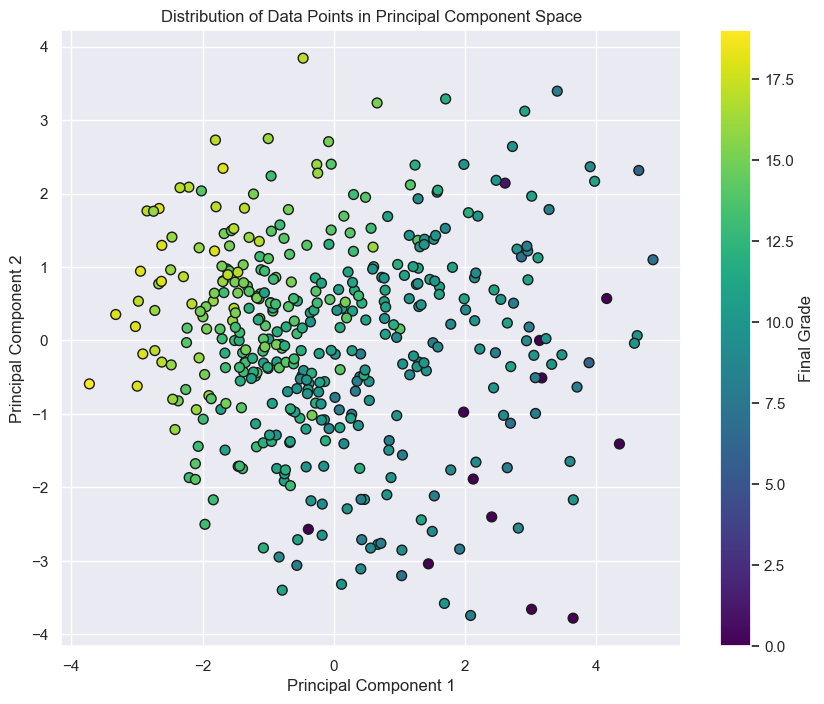

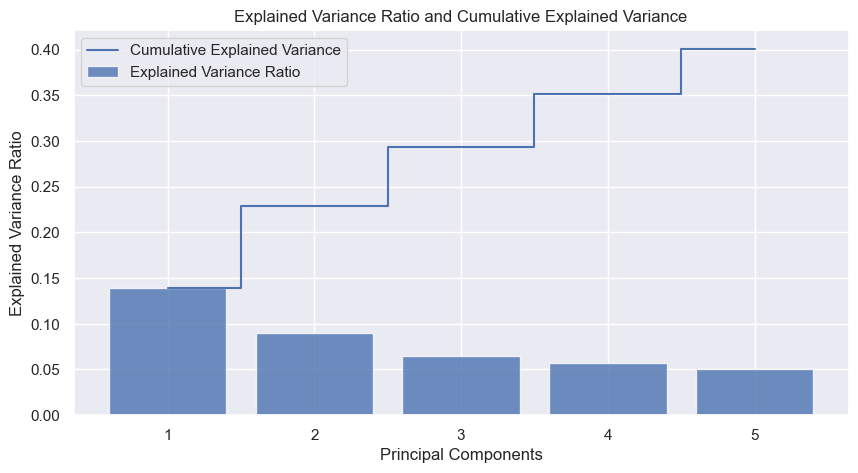

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error

file_path = "data/portuguese_train.csv"
data = pd.read_csv(file_path)

X = data.drop(["student_id", "final_grade"], axis=1)
y = data["final_grade"]

# Podela skupa na trening, validacioni i test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def apply_pca(X_train, X_val, X_test, num_components=5):
    # Kreiraj transformer za numeričke podatke
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_features = X_train.select_dtypes(include=['object']).columns
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Dodaj preprocesor u model
    pca_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=num_components))
    ])

    # Fituj model na trening podacima
    X_train_pca = pca_model.fit_transform(X_train)

    # Transformiši validacioni i test skup koristeći isti PCA model
    X_val_pca = pca_model.transform(X_val)
    X_test_pca = pca_model.transform(X_test)

    # Izdvoji PCA model kao zaseban objekat
    pca = pca_model.named_steps['pca']

    return X_train_pca, X_val_pca, X_test_pca, pca

# Pozovi funkciju za PCA model 
X_train_pca, X_val_pca, X_test_pca, pca = apply_pca(X_train, X_val, X_test)

# Prikazi explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = explained_var_ratio.cumsum()


# Vizualizacija raspodele tačaka u prostoru glavnih komponenti
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(label='Final Grade')
plt.title('Distribution of Data Points in Principal Component Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Vizualizacija objašnjene varijanse
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio, alpha=0.8, align='center', label='Explained Variance Ratio')
plt.step(range(1, len(explained_var_ratio) + 1), cumulative_var_ratio, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio and Cumulative Explained Variance')
plt.legend()
plt.show() 


4.	Treniranje i Evaluacija Modela:

•	Treniranje modela na trening setu.

•	Optimizacija parametara korišćenjem validacionog seta.

•	Evaluacija performansi modela na test setu.


Najbolji parametri: {'pca__n_components': 15}


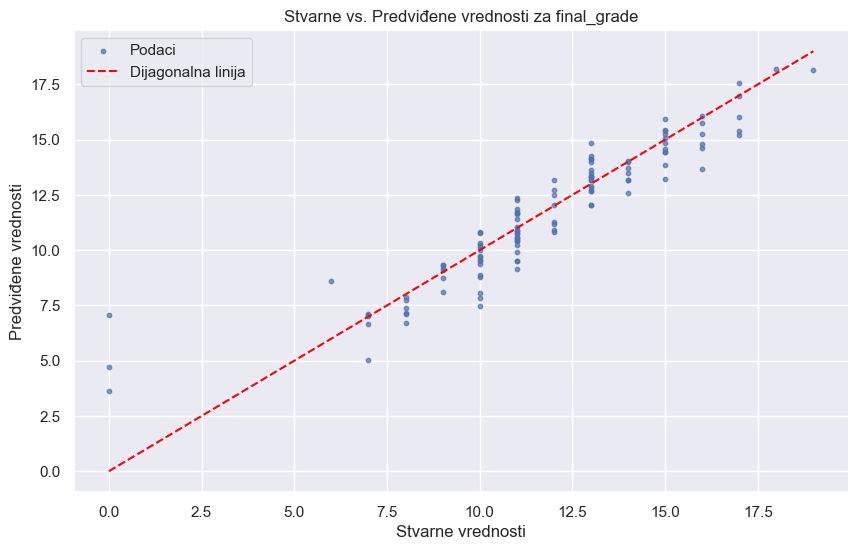

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Učitaj podatke
train_data = pd.read_csv("data/portuguese_train.csv")
test_data = pd.read_csv("data/portuguese_test.csv")

# Podela podataka na features (X) i ciljnu promenljivu (y)
X_train = train_data.drop(["student_id", "final_grade"], axis=1)
y_train = train_data["final_grade"]

# Podela na trening i validacioni skup
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Kreiranje modela sa PCA i linearnom regresijom
model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Dodajte preprocesor (npr. one-hot encoding) ovde
    ('pca', PCA()),
    ('linear_regression', LinearRegression())
])

# Definisanje parametara za optimizaciju
param_grid = {
    'pca__n_components': [5, 10, 15],  # Podesite prema potrebi
}

# Inicijalizujte GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fitujte model na trening podacima
grid_search.fit(X_train, y_train)

# Prikazi najbolje parametre tj. broj koliko glavnih parametara treba da imam da bi moj model bio najbolji 
print("Najbolji parametri:", grid_search.best_params_) 

# Predikcija na validacionom skupu
y_val_pred = grid_search.predict(X_val)

# Vizualizacija stvarnih vs. predviđenih vrednosti
plt.figure(figsize=(10, 6))

# Prikaz tačaka sa smanjenom veličinom
plt.scatter(y_val, y_val_pred, s=10, label='Podaci', alpha=0.7)

# Dijagonalna linija sa vlastitim vrednostima
diagonal_values = np.linspace(y_val.min(), y_val.max(), 100)
plt.plot(diagonal_values, diagonal_values, linestyle='--', color='red', label='Dijagonalna linija')

plt.xlabel("Stvarne vrednosti")
plt.ylabel("Predviđene vrednosti")
plt.title("Stvarne vs. Predviđene vrednosti za final_grade")
plt.legend()
plt.show()


5.	Analiza i Interpretacija Rezultata:

•	Analiza važnosti obeležja dobijenih iz modela.

•	Interpretacija uticaja različitih faktora na konačne ocene i odluku o upisu na visokoškolsko obrazovanje.


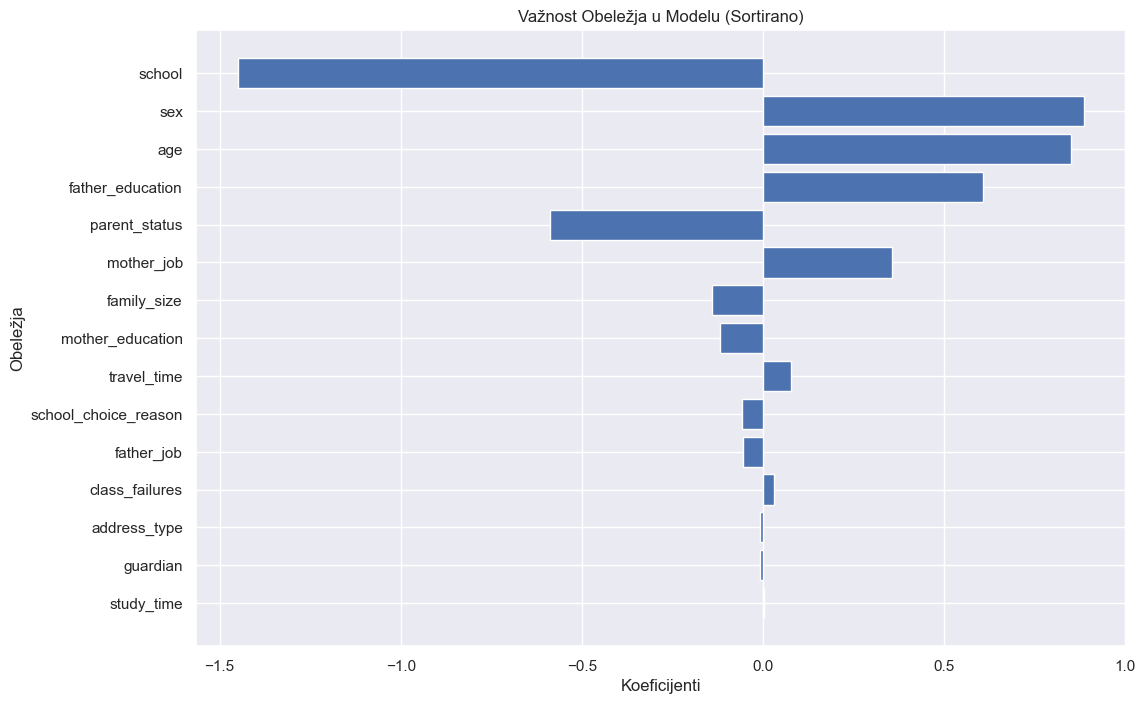

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Dobijanje koeficijenata linearnog modela
coefficients = grid_search.best_estimator_.named_steps['linear_regression'].coef_

# Sortiranje indeksa obeležja prema apsolutnim vrednostima koeficijenata
sorted_indices = np.argsort(np.abs(coefficients))

# Sortiranje obeležja i njihovih koeficijenata
sorted_features = X_train.columns[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

# Vizualizacija važnosti obeležja
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_coefficients)
plt.xlabel('Koeficijenti')
plt.ylabel('Obeležja')
plt.title('Važnost Obeležja u Modelu (Sortirano)')
plt.show()


In [30]:
import pandas as pd

# Učitaj podatke
data = pd.read_csv("data/portuguese_train.csv")

# Izračunaj verovatnoću
total_samples = len(data)
matching_samples = len(data[(data['sex'] == 'F') & (data['final_grade'] > 15)])

probability = matching_samples / total_samples

print(f"Verovatnoća da je final_grade > 15 kada je u pitanju ucenica: {probability:.2%}")

matching_samples = len(data[(data['sex'] == 'M') & (data['final_grade'] > 15)])

probability = matching_samples / total_samples

print(f"Verovatnoća da je final_grade > 15 kada je u pitanju ucenik: {probability:.2%}")


matching_samples = len(data[(data['father_education'] == 'higher education') & (data['final_grade'] > 15)])

probability = matching_samples / total_samples

print(f"Verovatnoća da je final_grade > 15 kada otac ima visoko obrazovanje: {probability:.2%}")


matching_samples = len(data[(data['father_education'] == 'secondary education') & (data['final_grade'] > 15)])

probability = matching_samples / total_samples

print(f"Verovatnoća da je final_grade > 15 kada otac ima secondary obrazovanje: {probability:.2%}")



matching_samples = len(data[(data['father_education'] == '5th to 9th grade') & (data['final_grade'] > 15)])

probability = matching_samples / total_samples

print(f"Verovatnoća da je final_grade > 15 kada otac ima 5th to 9th grade: {probability:.2%}")


Verovatnoća da je final_grade > 15 kada je u pitanju ucenica: 8.62%
Verovatnoća da je final_grade > 15 kada je u pitanju ucenik: 3.97%
Verovatnoća da je final_grade > 15 kada otac ima visoko obrazovanje: 4.31%
Verovatnoća da je final_grade > 15 kada otac ima secondary obrazovanje: 1.90%
Verovatnoća da je final_grade > 15 kada otac ima 5th to 9th grade: 4.14%
